# Hate Speech Detector 2.0
---
**Lexical text classifier**
1. Load sanitized tweets data about polish courts.
2. Lemmatize loaded tweets.
3. Load PAC scores for tweets from appropriate .csv file.
4. Find optimal thresholding values of above measures calculating classification accuracy (and other) as a quality score.
5. Visualize results.
6. Perform some test on independent sanitized tweets about polish courts.

In [2]:
import os
import csv

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from combo.predict import COMBO
import itertools

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

In [8]:
LABELS = ['wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie', 'poniżanie', 'stygmatyzacja', 'szantaż']
LABELS_SMALL = ['wyz', 'groz', 'wyk', 'odcz', 'pon', 'styg', 'szan']
SCORE_TYPES = ['min', 'mean', 'max']

HATEFUL_EXT_DIR = 'data/hateful/ext_{}.txt'
VULGARS_EXT_DIR = 'data/vulgars/ext_{}.txt'

DUPLICATED_PATH = 'data/tweets_sady/processed/sady_duplicated.csv'
POC_SCORES_PATH = 'data/tweets_sady/processed/poc_scores.csv'

TAGGER_MODEL = 'polish-herbert-base'

In [ ]:
plt.style.use('ggplot')

**Polish stopwords**

In [3]:
with open('data/other/polish_stopwords.txt', 'r') as f:
    polish_stopwords = f.read().split('\n')[:-1]
polish_stopwords[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

## Data loading

### Classes

In [ ]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

### Lemmatized tweets

### Extended hateful phrases

In [9]:
def load_ext_phrases(load_vulg=False):
    aphr = list([])
    for label in LABELS_SMALL:
        with open(HATEFUL_EXT_DIR.replace('{}', label), 'r') as f:
            aphr.append(np.array(f.read().split(';')))
    if load_vulg:
        with open(VULGARS_EXT_DIR.replace('{}', LABELS_V_SMALL[-1]), 'r') as f:
            aphr.append(np.array(f.read().split(';')))

    return np.array(aphr)

ext_phrases = load_ext_phrases()
ext_phrases[0][:5]

### Tweet POC scores for each class

In [13]:
df_poc_scores = pd.read_csv(POC_SCORES_PATH)
df_poc_scores.head(2)

,id,tweet,wyz_PAC_min,wyz_PAC_mean,wyz_PAC_max,wyz_label,groz_PAC_min,groz_PAC_mean,groz_PAC_max,groz_label,...,pon_PAC_max,pon_label,styg_PAC_min,styg_PAC_mean,styg_PAC_max,styg_label,szan_PAC_min,szan_PAC_mean,szan_PAC_max,szan_label
0,0,Dokładnie! Dlatego trzeba komuchów gonić prze...,-1.0,0.002574,1.0,1,-0.500000,-0.003554,0.00,0,...,0.250000,0,-0.5,0.000698,0.5,0,0.0,0.0,0.0,0
1,1,Polska Polityka: Sądy bardziej bezkarne niż w ...,0.0,0.000000,0.0,0,-0.333333,-0.000708,0.25,0,...,0.333333,0,-0.5,0.000097,0.5,0,0.0,0.0,0.0,0


### Combined data

In [ ]:
def combine_row_wisely(dfs):
    it = iter(dfs)
    length = len(next(it))
    if not all(len(l) == length for l in it):
        raise ValueError('Not all dataframes have the same length!')
    
    return pd.concat(dfs, axis=1)

def shuffle_dataframe(df):
    return df.sample(frac=1)

df_data = combine_row_wisely([df_poc_scores, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

## Optimal threshold values for min, mean and max POC

Perform k-fold cross-validation. Assume k value. Find the best train-test split.

In [ ]:
# in Python code

List all **distinct values** of **POC** scores for min, mean and max (as **threshold**), then predict label (if score is greater than of equals examined threshold then it is positive) and calculate **f measures** for **negative and positive** examples.

In [14]:
def f_stats(df):
    thresholds = dict({})
    f_neg_scores = dict({})
    f_pos_scores = dict({})

    for label, lsmall in tqdm(zip(LABELS, LABELS_SMALL)):
        for sc in SCORE_TYPES:
            poc_scores = np.array(df[f'{lsmall}_PAC_{sc}'])
            y_true = np.array(df[label])
            f0_scores, f1_scores = list([]), list([])
            
            u_poc_scores = np.unique(poc_scores)
            for poc_score in u_poc_scores:
                y_pred = np.array([1 if ps >= poc_score else 0 for ps in poc_scores])
                
                f_scores = f1_score(y_true=y_true, y_pred=y_pred, labels=[0, 1], average=None, zero_division=1.)
                f0_scores.append(f_scores[0])
                f1_scores.append(f_scores[1])

            thresholds[f'{lsmall}_{sc}'] = u_poc_scores
            f_neg_scores[f'{lsmall}_{sc}'] = np.array(f0_scores)
            f_pos_scores[f'{lsmall}_{sc}'] = np.array(f1_scores)
    
    return thresholds, f_neg_scores, f_pos_scores

thresholds, f_neg_scores, f_pos_scores = f_stats(df_data)

Estimate optimal POC (min, mean and max) thresholds for each hate-speech class, judging by f measures for positive and negative examples.

In [ ]:
def optimal_thresholds(thrs, f_negs, f_poss):
    optims = dict({})
    
    for lsmall in LABELS_SMALL:
        for sc in SCORE_TYPES:
            thr = thrs[f'{lsmall}_{sc}']
            f_neg = f_negs[f'{lsmall}_{sc}']
            f_pos = f_poss[f'{lsmall}_{sc}']
            
            optims[f'neg_{lsmall}_{sc}'] = thr[np.argmax(f_neg)]
            optims[f'pos_{lsmall}_{sc}'] = thr[np.argmax(f_pos)]
            del thr, f_neg, f_pos
    
    return optims

optimal_POCs = optimal_thresholds(thresholds, f_neg_scores, f_pos_scores)
optimal_POCs

In [15]:
def f_measure_lines(thrs, f0_s, f1_s, highlight_optims=True,
                     title='F measures for thresholds of min, mean and max POC.'):
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    
    titles = ['Minimum POC', 'Mean POC', 'Maximum POC']
    for i in range(3):
        ax[i].set_title(titles[i])
        ax[i].set_ylabel('Score')
        ax[i].set_xlabel('Threshold')
        ax[i].plot(thrs[i], f0_s[i])
        ax[i].plot(thrs[i], f1_s[i])

        if highlight_optims:
            mx, my = thrs[i][np.argmax(f0_s[i])], np.max(f0_s[i]) 
            ax[i].scatter([mx], [my], s=200, marker='*')
            ax[i].annotate(f'({mx:.2f}, {my:.2f})', xy=(mx, my), fontsize=20)
            mx, my = thrs[i][np.argmax(f1_s[i])], np.max(f1_s[i]) 
            ax[i].scatter([mx], [my], s=200, marker='*')
            ax[i].annotate(f'({mx:.2f}, {my:.2f})', xy=(mx, my), fontsize=20)
    '''
    ax[1].set_title('Mean PAC')
    ax[1].set_ylabel('Score')
    ax[1].set_xlabel('Threshold')
    ax[1].plot(thrs[1], f0_s[1])
    ax[1].plot(thrs[1], f1_s[1])
    
    if highlight_optims:
        mx, my = thrs[1][np.argmax(f0_s[1])], np.max(f0_s[1]) 
        ax[1].scatter([mx], [my], s=200, marker='*', label='max F0')
        ax[1].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
        mx, my = thrs[1][np.argmax(f1_s[1])], np.max(f1_s[1]) 
        ax[1].scatter([mx], [my], s=200, marker='*', label='max F1 ')
        ax[1].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    
    ax[2].set_title('Maximum PAC')
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel('Threshold')
    ax[2].plot(thrs[2], f0_s[2])
    ax[2].plot(thrs[2], f1_s[2])
    
    if highlight_optims:
        mx, my = thrs[2][np.argmax(f0_s[2])], np.max(f0_s[2]) 
        ax[2].scatter([mx], [my], s=200, marker='*')
        ax[2].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
        mx, my = thrs[2][np.argmax(f1_s[2])], np.max(f1_s[2]) 
        ax[2].scatter([mx], [my], s=200, marker='*')
        ax[2].annotate(f'({np.round(mx, 2)}, {np.round(my, 2)})', xy=(mx, my), fontsize=20)
    '''
    
    # custom legend
    legend_lines = [Line2D([0], [0], color='#e24a33', lw=2, label='F0'),
                    Line2D([0], [0], color='#348abd', lw=2, label='F1'),
                    Line2D([0], [0], marker='*', color='#e24a33', markersize=15, label='max F0'),
                    Line2D([0], [0], marker='*', color='#348abd', markersize=15, label='max F1')]
    fig.legend(handles=legend_lines[:2], loc='upper left')
    fig.legend(handles=legend_lines[2:], loc='upper right')
    
    fig.suptitle(title)
    #plt.tight_layout()
    #if save_file:
    #    plt.savefig(save_file)
    plt.show()

In [ ]:
for label, lsmall in zip(LABELS, LABELS_SMALL):
    f_measure_lines([thresholds[f'{lsmall}_{sc}'] for sc in SCORE_TYPES],
                    [f_neg_scores[f'{lsmall}_{sc}'] for sc in SCORE_TYPES],
                    [f_pos_scores[f'{lsmall}_{sc}'] for sc in SCORE_TYPES],
                    title=f'F measures for thresholds of min, mean and max POC for class {label}.')

## Classifier tests

In [31]:
def get_POC(lemm_tweet, phrs):
    scores = list([])

    for label, phrases in zip(LABELS_V_SMALL, phrs):
        sc_min, sc_mean, sc_max = list([]), list([]), list([])

        for phrase in phrases:
            mn, mean, mx = POC(lemm_tweet, phrase, lemmatized=True, stopwords=POLISH_STOPWORDS)
            sc_min.append(mn)
            sc_mean.append(mean)
            sc_max.append(mx)

        scores.append(np.min(sc_min))
        scores.append(np.mean(sc_mean))
        scores.append(np.max(sc_max))

        del sc_min, sc_mean, sc_max

    return scores

def predict(scores, optims):
    scores = scores.reshape(-1, 3)
    pred = np.zeros(len(LABELS_SMALL), dtype=np.uint8)
    
    for i, lsmall in enumerate(LABELS_SMALL):
        if scores[i][0] >= optims[f'pos_{lsmall}_min'] and\
           scores[i][1] >= optims[f'pos_{lsmall}_mean'] and\
           scores[i][2] >= optims[f'pos_{lsmall}_max']:
            pred[i] = 1.
    
    return pred

### Test for all data
Predict for all data for each hate-speech class.

In [32]:
def test_data(df, optims):
    y_trues, y_preds = list([]), list([])

    for label, lsmall in zip(LABELS, LABELS_SMALL):
        y_min = df[f'{lsmall}_POC_min'].values
        y_mean = df[f'{lsmall}_POC_mean'].values
        y_max = df[f'{lsmall}_POC_max'].values

        min_thr = optims[f'pos_{lsmall}_min']
        mean_thr = optims[f'pos_{lsmall}_mean']
        max_thr = optims[f'pos_{lsmall}_max']
        
        y_true = df[label].values
        y_pred = np.array([ 1 if mn >= min_thr and me >= mean_thr and mx >= max_thr else 0
                           for mn, me, mx in zip(y_min, y_mean, y_max)])
        y_trues.append(y_true)
        y_preds.append(y_pred)

        del y_min, y_mean, y_max, min_thr, mean_thr, max_thr
    
    return np.array(y_trues), np.array(y_preds)

trues, preds = test_data(df_data, optimal_POCs)

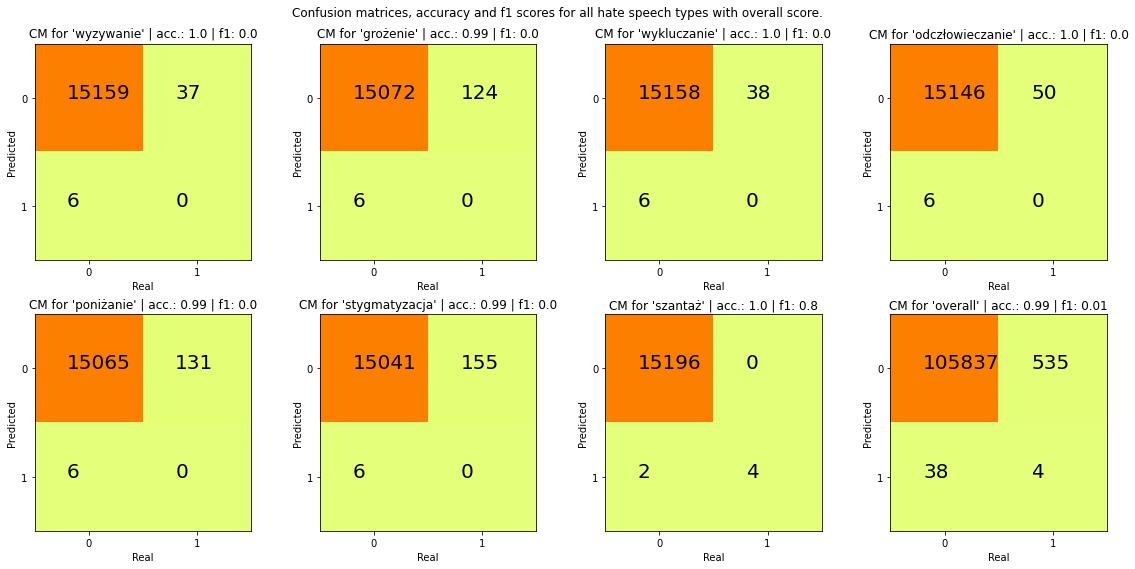

In [35]:
def confusion_matrices(y_trues, y_preds,
                       title='Confusion matrices with F measures for all hate-speech classes with overall score.')
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    positions = list([tuple((i, j)) for i in range(2) for j in range(4)])
    labels = LABELS + ['overall']

    for i, (p, label, y_true, y_pred) in enumerate(zip(positions, labels, y_trues, y_preds)):

        acc = accuracy_score(y_true=y_true, y_pred=y_pred)
        f0, f1 = f1_score(y_true=y_true, y_pred=y_pred, labels=[0, 1], average=None, zero_division=1.)
        cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])

        #acc = np.round(accuracy_cm(conf_matrices[ht]), 2)
        #f1 = np.round(f1_cm(conf_matrices[ht]), 2)
        ax[p[0]][p[1]].set_title(f'CM for "{label}" | f0: {f0:.2f} | f1: {f1:.2f}')
        ax[p[0]][p[1]].set_ylabel('Predicted')
        ax[p[0]][p[1]].set_xlabel('Actual')

        ax[p[0]][p[1]].imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
        tick_marks = np.arange(2)
        ax[p[0]][p[1]].set_xticks(tick_marks)
        ax[p[0]][p[1]].set_yticks(tick_marks)

        for i in range(2):
            for j in range(2):
                ax[p[0]][p[1]].text(j - 0.2, i, f'{cm[i][j]}', fontsize=20)

    fig.suptitle(title)

    #plt.tight_layout()
    #plt.savefig('charts/lexical_classifier/conf_matrices.png')
    plt.show()

confusion_matrices()

In [ ]:
def test(text):
    lemm = lemmatize_text(text)
    poc = get_POC(lemm, ext_phrases)
    preds = predict(poc, optimal_POCs)
    
    return preds

### Test 1

In [36]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = test(test_text1)
dict(zip(LABELS, preds1))

'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'

### Test 2

In [39]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = test(test_text2)
dict(zip(LABELS, preds2))

'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'

### Test 3

In [42]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = test(test_text3)
dict(zip(LABELS, preds3))

'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '